In [1]:
# import libraries

# data processing
import numpy as np
import pandas as pd
#import geopandas as gpd
import missingno as msno

# visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
#import folium

In [2]:
# palette
pal = ['#EF585D', # red
       '#016E6F', # green
       '#494949', # dark-grey
       '#8C1845', # purple
       '#FFB401', # yellow
       '#D93801', # saffron
       '#EBEBEB'] # light-grey
sns.set_style("whitegrid")

In [3]:
# plotly offline
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [4]:
# import dataset
df = pd.read_csv('data/listings.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2265,Zen-East in the Heart of Austin (monthly rental),2466,Paddy,NaN,78702,30.27750,-97.71398,Entire home/apt,225,30,24,2019-03-16,0.18,3,0
1,5245,"Eco friendly, Colorful, Clean, Cozy monthly share",2466,Paddy,NaN,78702,30.27577,-97.71379,Private room,100,30,9,2018-03-14,0.07,3,0
2,5456,"Walk to 6th, Rainey St and Convention Ctr",8028,Sylvia,NaN,78702,30.26112,-97.73448,Entire home/apt,95,2,529,2020-03-01,3.94,1,334
3,5769,NW Austin Room,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,40,1,257,2019-11-03,2.12,1,14
4,6413,Gem of a Studio near Downtown,13879,Todd,NaN,78704,30.24829,-97.73726,Entire home/apt,99,3,112,2020-03-08,0.90,1,0


In [5]:
# shape
df.shape

(11668, 16)

In [6]:
# columns
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [7]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11668 entries, 0 to 11667
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              11668 non-null  int64  
 1   name                            11668 non-null  object 
 2   host_id                         11668 non-null  int64  
 3   host_name                       11666 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   11668 non-null  int64  
 6   latitude                        11668 non-null  float64
 7   longitude                       11668 non-null  float64
 8   room_type                       11668 non-null  object 
 9   price                           11668 non-null  int64  
 10  minimum_nights                  11668 non-null  int64  
 11  number_of_reviews               11668 non-null  int64  
 12  last_review                     

In [12]:
# no. of missing values
#df.isna().sum()

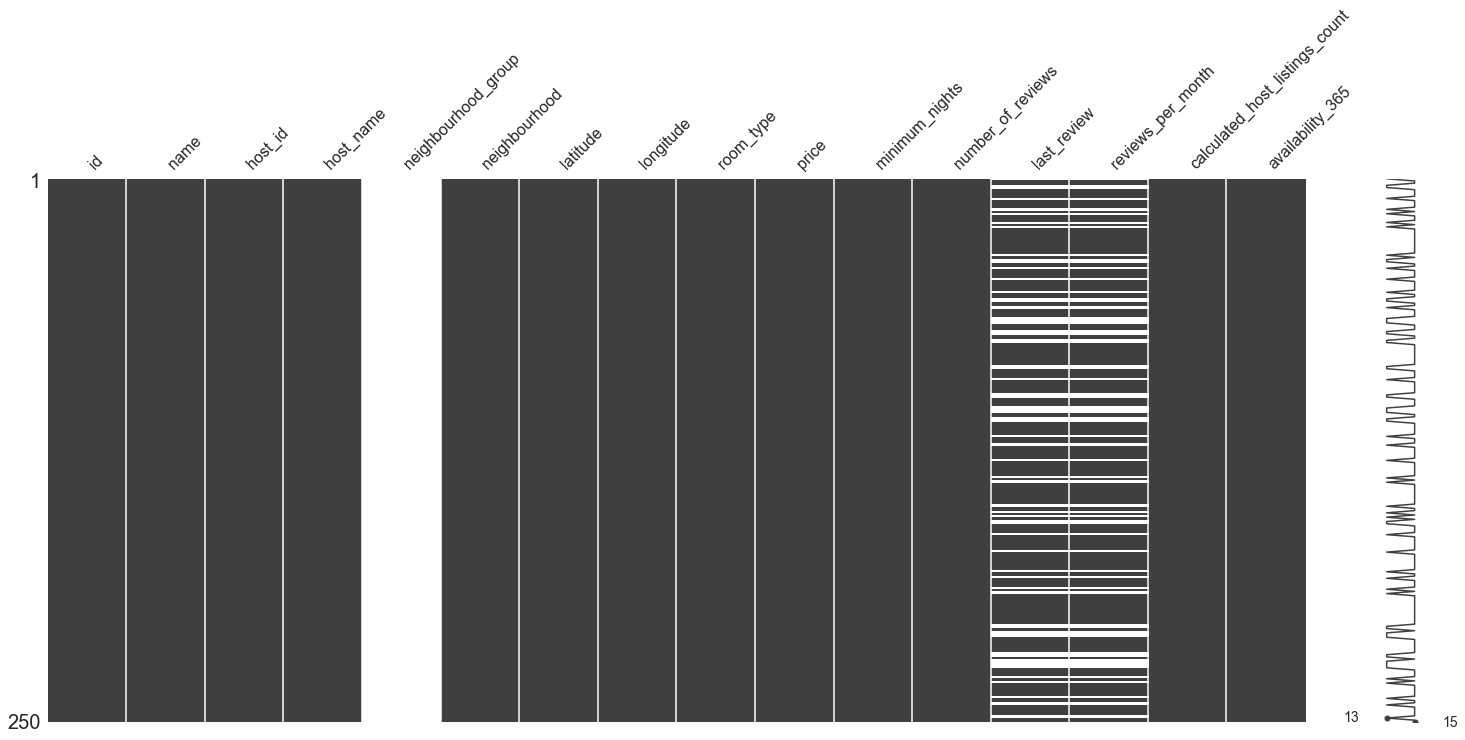

In [15]:
msno.matrix(df.sample(250))

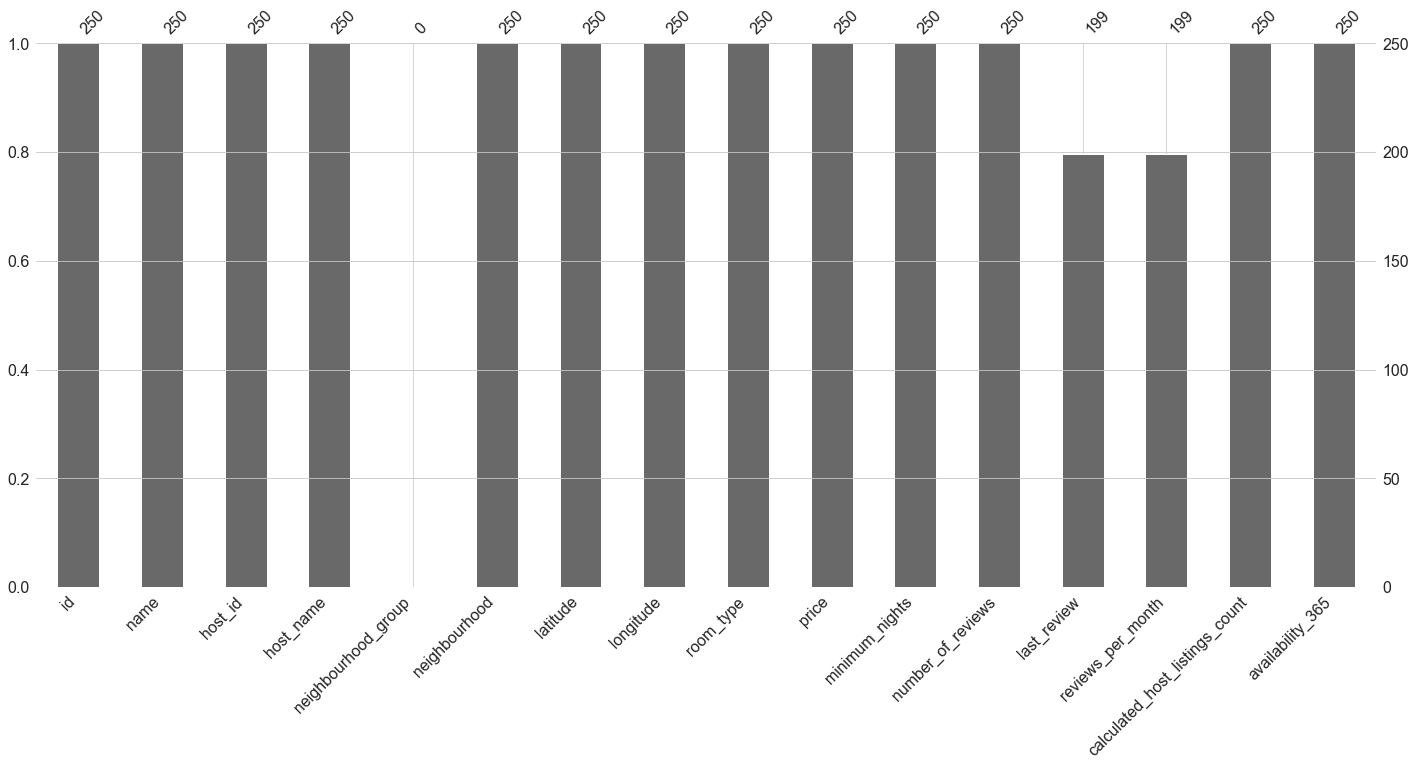

In [10]:
msno.bar(df.sample(250))

In [11]:
# describe for price
df['price'].describe()

count    11668.000000
mean       484.237830
std       1480.352627
min          0.000000
25%         80.000000
50%        149.000000
75%        300.000000
max      14298.000000
Name: price, dtype: float64

In [16]:
# no. of unique values
df.nunique()

id                                11668
name                              11423
host_id                            7639
host_name                          2928
neighbourhood_group                   0
neighbourhood                        44
latitude                           8171
longitude                          7780
room_type                             4
price                               706
minimum_nights                       48
number_of_reviews                   388
last_review                        1033
reviews_per_month                   835
calculated_host_listings_count       37
availability_365                    366
dtype: int64

In [21]:
# value counts by room_type
print(df['room_type'].value_counts())

Entire home/apt    8848
Private room       2610
Shared room         159
Hotel room           51
Name: room_type, dtype: int64


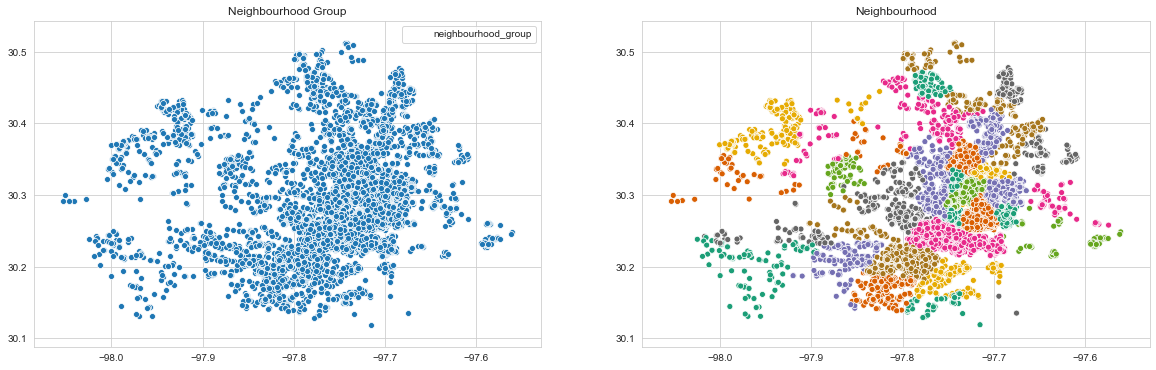

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.scatterplot(data=df, x='longitude', y='latitude', hue='neighbourhood_group', palette='Dark2', ax=axes[0])
sns.scatterplot(data=df, x='longitude', y='latitude', hue='neighbourhood', legend=False, palette='Dark2', ax=axes[1])

axes[0].set_title('Neighbourhood Group')
axes[1].set_title('Neighbourhood')
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlabel('')

plt.show()

C:\Users\rtalebiz\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

divide by zero encountered in log



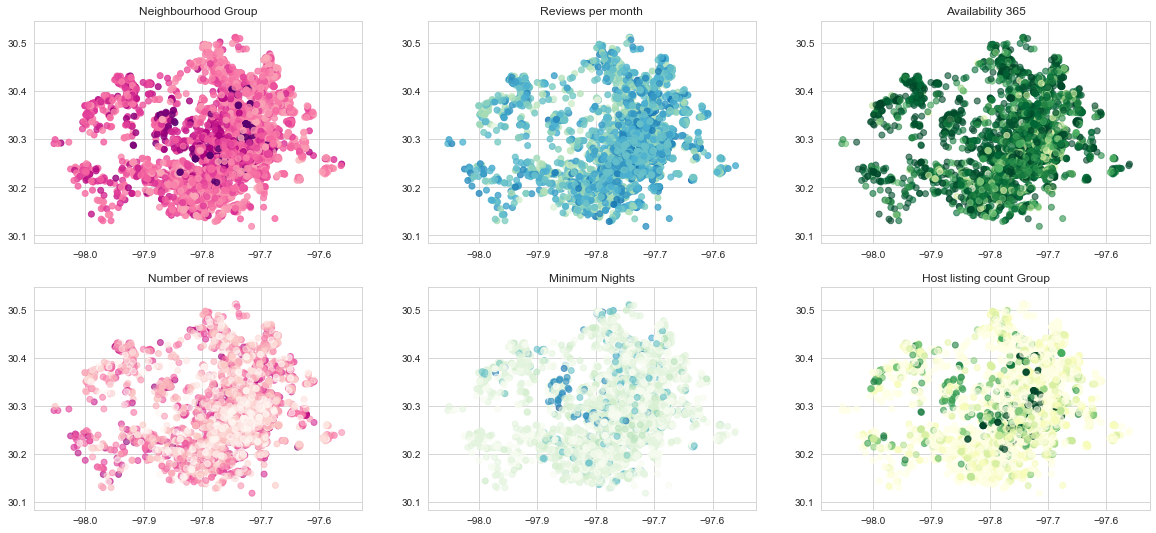

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

axes[0,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['price']), cmap='RdPu', alpha=0.8)
axes[0,0].set_title('Neighbourhood Group')

axes[0,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['reviews_per_month']), cmap='GnBu', alpha=0.8)
axes[0,1].set_title('Reviews per month')

axes[0,2].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['availability_365']), cmap='YlGn', alpha=0.6)
axes[0,2].set_title('Availability 365')

axes[1,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['number_of_reviews']), cmap='RdPu', alpha=0.6)
axes[1,0].set_title('Number of reviews')

axes[1,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['minimum_nights']), cmap='GnBu', alpha=0.6)
axes[1,1].set_title('Minimum Nights')

axes[1,2].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['calculated_host_listings_count']), cmap='YlGn', alpha=0.6)
axes[1,2].set_title('Host listing count Group')

plt.show()

### Costliest neighbourhood

In [26]:
# costliest neighbourhood_group
temp = df.groupby(['neighbourhood_group'])['price'].mean().reset_index()
temp = temp.sort_values('price', ascending=False).reset_index(drop=True)

ax = sns.barplot(data=temp, x='price', y='neighbourhood_group', palette='Dark2')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean price from each neighbourhood_group')
plt.show()

ValueError: min() arg is an empty sequence